In [132]:
from pathlib import Path
import pandas as pd
import numpy as np

# -------- path helper (same as in 01GNDataPipeline) -------- #
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(
        f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels."
    )

# -------- files -------- #
DATA_DIR   = find_upwards(Path("GrossToNet/Data"))
DEALS_CSV  = DATA_DIR / "deal_cash_flow.csv"
FUNDS_CSV  = DATA_DIR / "fund_cash_flow.csv"
MAP_CSV    = DATA_DIR / "deal_to_fund.csv"  # optional

date_parser = lambda s: pd.to_datetime(s, format="%Y-%m-%d", errors="coerce")

# --- load cash flows (dates are yyyy-mm-dd) ---
deals = pd.read_csv(
    DEALS_CSV,
    dtype={"id": str, "deal_id": str},
)
funds = pd.read_csv(
    FUNDS_CSV,
    dtype={"id": str, "fund_id": str},
)

# parse dates explicitly (yyyy-mm-dd)
deals["cash_flow_date"] = pd.to_datetime(deals["cash_flow_date"], format="%Y-%m-%d", errors="coerce")
funds["cash_flow_date"] = pd.to_datetime(funds["cash_flow_date"], format="%Y-%m-%d", errors="coerce")

# standardize column names
deals = deals.rename(columns={"cash_flow_date": "date", "cash_flow": "amount"})
funds = funds.rename(columns={"cash_flow_date": "date", "cash_flow": "amount"})


# optional: deal→fund map (if present)
if MAP_CSV.exists():
    deal_to_fund = pd.read_csv(MAP_CSV, dtype={"deal_id": str, "fund_id": str})
else:
    deal_to_fund = pd.DataFrame(columns=["deal_id", "fund_id"])

# quick sanity checks
assert {"id", "deal_id", "amount", "date"}.issubset(deals.columns), deals.columns
assert {"id", "fund_id", "amount", "date"}.issubset(funds.columns), funds.columns


In [133]:
# ---------- Normalize types and enforce sign conventions ---------- #

# Pre-checks
req_f_cols = {"id", "fund_id", "amount", "date", "cash_flow_type"}
req_d_cols = {"id", "deal_id", "amount", "date", "cash_flow_type"}
assert req_f_cols.issubset(funds.columns), f"Missing in funds: {req_f_cols - set(funds.columns)}"
assert req_d_cols.issubset(deals.columns), f"Missing in deals: {req_d_cols - set(deals.columns)}"
assert pd.api.types.is_datetime64_any_dtype(funds["date"]), "funds.date must be datetime"
assert pd.api.types.is_datetime64_any_dtype(deals["date"]), "deals.date must be datetime"
assert funds["amount"].dtype.kind in "fi", "funds.amount must be numeric"
assert deals["amount"].dtype.kind in "fi", "deals.amount must be numeric"
assert funds["date"].notna().all(), "NaT in funds.date"
assert deals["date"].notna().all(), "NaT in deals.date"

# Canonicalize cash_flow_type
funds_map = {
    "contribution": "contribution",
    "distribution": "distribution",
    "nav": "nav",
}
deals_map = {
    "investment": "investment",
    "proceed": "proceed",
    "fair value": "fair_value",
}

funds["type_std"] = (
    funds["cash_flow_type"].astype(str).str.strip().str.lower().map(funds_map)
)
deals["type_std"] = (
    deals["cash_flow_type"].astype(str).str.strip().str.lower().map(deals_map)
)

# Validate types are known
unknown_f = funds[funds["type_std"].isna()]["cash_flow_type"].value_counts()
unknown_d = deals[deals["type_std"].isna()]["cash_flow_type"].value_counts()
assert unknown_f.empty, f"Unknown funds cash_flow_type: \n{unknown_f}"
assert unknown_d.empty, f"Unknown deals cash_flow_type: \n{unknown_d}"

# Enforce signs deterministically (use abs to avoid double flips)
# Funds: contribution negative; distribution/NAV non-negative
funds.loc[funds["type_std"] == "contribution", "amount"] = -funds.loc[
    funds["type_std"] == "contribution", "amount"
].abs()
funds.loc[funds["type_std"].isin(["distribution", "nav"]), "amount"] = funds.loc[
    funds["type_std"].isin(["distribution", "nav"]), "amount"
].abs()

# Deals: investment negative; proceed/fair_value non-negative
deals.loc[deals["type_std"] == "investment", "amount"] = -deals.loc[
    deals["type_std"] == "investment", "amount"
].abs()
deals.loc[deals["type_std"].isin(["proceed", "fair_value"]), "amount"] = deals.loc[
    deals["type_std"].isin(["proceed", "fair_value"]), "amount"
].abs()

# Post-conditions: strict sign checks
assert (funds.loc[funds["type_std"] == "contribution", "amount"] <= 0).all(), \
    "Found positive contribution amounts in funds."
assert (funds.loc[funds["type_std"].isin(["distribution", "nav"]), "amount"] >= 0).all(), \
    "Found negative distribution/NAV amounts in funds."

assert (deals.loc[deals["type_std"] == "investment", "amount"] <= 0).all(), \
    "Found positive investment amounts in deals."
assert (deals.loc[deals["type_std"].isin(["proceed", "fair_value"]), "amount"] >= 0).all(), \
    "Found negative proceed/fair_value amounts in deals."

# Quick summaries (useful for spot checks)
print("Funds types:\n", funds["type_std"].value_counts(dropna=False).to_string())
print("Deals types:\n", deals["type_std"].value_counts(dropna=False).to_string())
print(
    "Funds sign check:",
    {
        "contribution_min": float(funds.loc[funds.type_std=="contribution","amount"].min())
            if (funds.type_std=="contribution").any() else None,
        "dist_nav_min": float(funds.loc[funds.type_std.isin(["distribution","nav"]),"amount"].min())
            if (funds.type_std.isin(["distribution","nav"])).any() else None,
    }
)
print(
    "Deals sign check:",
    {
        "investment_min": float(deals.loc[deals.type_std=="investment","amount"].min())
            if (deals.type_std=="investment").any() else None,
        "proc_fv_min": float(deals.loc[deals.type_std.isin(["proceed","fair_value"]),"amount"].min())
            if (deals.type_std.isin(["proceed","fair_value"])).any() else None,
    }
)


Funds types:
 type_std
contribution    4597
distribution    2583
nav              120
Deals types:
 type_std
proceed       5977
investment    5605
fair_value     410
Funds sign check: {'contribution_min': -17352054794.5205, 'dist_nav_min': 5.551115123125779e-11}
Deals sign check: {'investment_min': -3285071667.0, 'proc_fv_min': 0.0}


In [134]:
from pathlib import Path
import pandas as pd
import numpy as np

# ---------- Locate & read monthly FX (Excel-serial dates; wide -> tidy) ----------
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

FX_WIDE_CSV = find_upwards(Path("InputData/currencies.csv"))
fx_wide = pd.read_csv(FX_WIDE_CSV)

# Validate minimal structure
assert "date" in fx_wide.columns, f"'date' column missing in {FX_WIDE_CSV}"
ccy_cols = [c for c in fx_wide.columns if c != "date"]
assert ccy_cols, "No currency columns found in currencies.csv (expected like USD, EUR, GBP, ...)."

# Convert Excel serial to datetime (assumed month-end values)
fx_wide["date"] = pd.to_datetime(pd.to_numeric(fx_wide["date"], errors="coerce"), unit="D",
                                 origin="1899-12-30", errors="coerce")
assert fx_wide["date"].notna().all(), "Failed to parse some FX dates from Excel serials."

# Melt to tidy; normalize currency codes; keep numeric
fx = (
    fx_wide.melt(id_vars="date", var_name="currency", value_name="fx_to_USD")
          .assign(currency=lambda d: d["currency"].astype(str).str.strip().str.upper())
)
# Coerce to numeric; drop fully empty rows
fx["fx_to_USD"] = pd.to_numeric(fx["fx_to_USD"], errors="coerce")
fx = fx.dropna(subset=["fx_to_USD"])

# Enforce uniqueness per (date,currency)
dup = fx.duplicated(subset=["date","currency"])
assert not dup.any(), f"Duplicate FX rows for same (date,currency). Examples:\n{fx.loc[dup, ['date','currency']].head()}"

# For monthly alignment: compute month-end for FX dates (defensive; should already be month-end)
fx["month_end"] = fx["date"] + pd.offsets.MonthEnd(0)
fx = fx[["month_end","currency","fx_to_USD"]].rename(columns={"month_end":"date_me"}).sort_values(["currency","date_me"])

# ---------- Prepare deals for FX join (align to month-end) ----------
# Requirements already ensured upstream: deals has ['date','amount','currency','deal_id'] and 'date' is datetime64
req_deal_cols = {"deal_id","date","amount","currency"}
assert req_deal_cols.issubset(deals.columns), f"Deals missing {req_deal_cols - set(deals.columns)}"
assert pd.api.types.is_datetime64_any_dtype(deals["date"]), "deals.date must be datetime"

deals["currency"] = deals["currency"].astype(str).str.strip().str.upper()
deals["date_me"] = deals["date"] + pd.offsets.MonthEnd(0)

# Left-join by nearest past (exact month match via key equality; if your FX is strictly one per month, direct merge is fine)
deals_fx = deals.merge(fx, left_on=["date_me","currency"], right_on=["date_me","currency"], how="left")

# Compute USD amount (USD column in FX is 1.0 ⇒ values are USD per unit of currency)
deals_fx["amount_usd"] = deals_fx["amount"] * deals_fx["fx_to_USD"]

# ---------- Prepare funds for FX join (via fund_currency) ----------
# If all funds are already USD, conversion is identity; otherwise join on fund_currency.
req_fund_cols = {"fund_id","date","amount"}
assert req_fund_cols.issubset(funds.columns), f"Funds missing {req_fund_cols - set(funds.columns)}"
assert pd.api.types.is_datetime64_any_dtype(funds["date"]), "funds.date must be datetime"

# Prefer previously added 'fund_currency' (from your enrichment step). If absent, fall back to a generic 'currency' if it exists.
fund_currency_col = "fund_currency" if "fund_currency" in funds.columns else ("currency" if "currency" in funds.columns else None)
assert fund_currency_col is not None, "Funds currency column not found (expected 'fund_currency' or 'currency')."

funds["date_me"] = funds["date"] + pd.offsets.MonthEnd(0)
funds[fund_currency_col] = funds[fund_currency_col].astype(str).str.strip().str.upper()

if (funds[fund_currency_col] == "USD").all():
    funds_fx = funds.copy()
    funds_fx["fx_to_USD"] = 1.0
    funds_fx["amount_usd"] = funds_fx["amount"]
else:
    funds_fx = funds.merge(
        fx.rename(columns={"currency":"fund_ccy"}),
        left_on=["date_me", fund_currency_col],
        right_on=["date_me", "fund_ccy"],
        how="left"
    )
    funds_fx["amount_usd"] = funds_fx["amount"] * funds_fx["fx_to_USD"]

# ---------- QA / Coverage Reporting ----------
def coverage_report(df, id_col, ccy_col_name):
    missing = df[df["fx_to_USD"].isna()]
    total_rows = len(df)
    missing_rows = len(missing)
    missing_groups = missing[id_col].nunique(dropna=False) if id_col in df.columns else np.nan
    # Identify cases where currency exists but its series starts later than the cash-flow date’s month
    # Heuristic: if currency has any FX rows at all, but for this date_me there is no match.
    has_series = df[ccy_col_name].map(df[ccy_col_name].dropna().unique().__contains__)
    # (Above is always True; better check in FX table:)
    ccy_has_fx = df[ccy_col_name].isin(fx["currency"].unique())
    late_start = missing[ccy_col_name].isin(fx["currency"].unique())

    print(f"[FX] {id_col}: {missing_groups} group(s) with at least one row missing FX; "
          f"row coverage {total_rows - missing_rows}/{total_rows} "
          f"({(total_rows - missing_rows)/total_rows:.1%}).")
    if not missing.empty:
        samp = missing[[id_col, ccy_col_name, "date_me"]].head(10)
        print(f"[FX] Sample missing ({id_col}, {ccy_col_name}, date_me):")
        print(samp.to_string(index=False))
        # Optional: show first available FX date per missing currency to indicate late starts
        first_fx = fx.groupby("currency")["date_me"].min()
        joined = (
            missing[[ccy_col_name]].assign(first_fx=lambda d: d[ccy_col_name].map(first_fx))
            .drop_duplicates()
            .sort_values(ccy_col_name)
            .head(10)
        )
        print("[FX] First available FX date per missing currency (sample):")
        print(joined.to_string(index=False))

# Deals coverage
coverage_report(deals_fx, id_col="deal_id", ccy_col_name="currency")

# Funds coverage
coverage_report(funds_fx, id_col="fund_id", ccy_col_name=(fund_currency_col if fund_currency_col in funds_fx.columns else "currency"))

# ---------- Persist back (optional) ----------
# If you want to overwrite your CSVs with USD amounts appended:
DATA_DIR = find_upwards(Path("GrossToNet/Data"))
DEALS_CSV = DATA_DIR / "deal_cash_flow.csv"
FUNDS_CSV = DATA_DIR / "fund_cash_flow.csv"

# Keep original columns + new FX outputs, preserve order
deal_cols_order = list(deals.columns) + [c for c in ["fx_to_USD","amount_usd"] if c not in deals.columns]
fund_cols_order = list(funds.columns) + [c for c in ["fx_to_USD","amount_usd"] if c not in funds.columns]

deals_out = deals_fx[deal_cols_order]
funds_out = funds_fx[fund_cols_order]

deals_out.to_csv(DEALS_CSV, index=False)
funds_out.to_csv(FUNDS_CSV, index=False)

print(f"[FX] Wrote USD amounts to:\n- {DEALS_CSV}\n- {FUNDS_CSV}")

# ---------- Sanity assertions ----------
# USD rows must have fx_to_USD == 1 within tolerance
usd_deals = deals_fx["currency"] == "USD"
if usd_deals.any():
    assert np.isfinite(deals_fx.loc[usd_deals, "fx_to_USD"]).all(), "Missing USD FX on USD rows."
    assert (deals_fx.loc[usd_deals, "fx_to_USD"].round(6) == 1.0).all(), "USD rate not equal to 1.0 for USD rows."
usd_funds = (funds_fx.get("fund_ccy", funds_fx.get(fund_currency_col)) == "USD")
if usd_funds.any():
    assert np.isfinite(funds_fx.loc[usd_funds, "fx_to_USD"]).all(), "Missing USD FX on USD funds."
    assert (funds_fx.loc[usd_funds, "fx_to_USD"].round(6) == 1.0).all(), "USD rate not equal to 1.0 for USD funds."

# No NaT introduced; amount_usd finite where fx exists
assert deals_fx["date_me"].notna().all() and funds_fx["date_me"].notna().all(), "NaT in month-end alignment."
assert np.isfinite(deals_fx.loc[deals_fx["fx_to_USD"].notna(), "amount_usd"]).all(), "Non-finite USD in deals."
assert np.isfinite(funds_fx.loc[funds_fx["fx_to_USD"].notna(), "amount_usd"]).all(), "Non-finite USD in funds."

# Drop entire deal_id groups with missing FX
invalid_fx_deal_ids = (
    deals_fx.groupby("deal_id")["fx_to_USD"]
            .apply(lambda s: s.isna().any())
            .pipe(lambda s: s[s].index.tolist())
)

before_rows  = len(deals_fx)
before_groups = deals_fx["deal_id"].nunique()

deals_fx = deals_fx[~deals_fx["deal_id"].isin(invalid_fx_deal_ids)].copy()

after_rows   = len(deals_fx)
after_groups = deals_fx["deal_id"].nunique()

print(f"[FX-CLEAN] Removed {len(invalid_fx_deal_ids)} deal_id groups due to missing FX "
      f"({before_groups} -> {after_groups}); rows {before_rows} -> {after_rows}.")
if invalid_fx_deal_ids:
    print("Sample removed deal_ids:", invalid_fx_deal_ids[:10])

# (Optional) persist
DATA_DIR = find_upwards(Path("GrossToNet/Data"))
DEALS_CSV = DATA_DIR / "deal_cash_flow.csv"

# Keep prior column order + fx_to_USD, amount_usd
deal_cols_order = [c for c in deals.columns] + [c for c in ["fx_to_USD","amount_usd","date_me"] if c not in deals.columns]
deals_out = deals_fx[deal_cols_order]
deals_out.to_csv(DEALS_CSV, index=False)
print(f"[FX-CLEAN] Wrote cleaned deals to {DEALS_CSV}")


[FX] deal_id: 26 group(s) with at least one row missing FX; row coverage 11786/11992 (98.3%).
[FX] Sample missing (deal_id, currency, date_me):
                             deal_id currency    date_me
7182b64e-3988-4be1-b724-a8c70217617c      SEK 1994-12-31
a0350859-5efa-4469-a8a0-b5a34e47bab6      SEK 1994-12-31
45cb2fd4-f7d4-4e8d-9645-ebbee3b736f1      SEK 1994-12-31
d9cad0e5-2c17-4f35-bdf7-fdee7f097efe      SEK 1994-12-31
2a40b3c4-ff38-443f-be74-615ee975252a      SEK 1994-12-31
5ecb8a82-c674-4abb-83c6-ec6c175842e2      SEK 1994-12-31
7af1e766-ad13-46e4-8c37-63ce22dbc930      SEK 1994-12-31
a2350b86-92f9-4c58-8f87-6f4de4841e76      SEK 1994-12-31
37014c9b-4b7e-4517-b2e8-0410a06b1551      SEK 1994-12-31
a0350859-5efa-4469-a8a0-b5a34e47bab6      SEK 1994-12-31
[FX] First available FX date per missing currency (sample):
currency   first_fx
     SEK 2005-02-28
[FX] fund_id: 0 group(s) with at least one row missing FX; row coverage 7300/7300 (100.0%).
[FX] Wrote USD amounts to:
- /Users/m

In [135]:
from pathlib import Path
import pandas as pd
import numpy as np

# ---------- helpers ----------
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

def excel_serial_to_dt(s):
    ser = pd.to_numeric(s, errors="coerce")
    return pd.to_datetime(ser, unit="D", origin="1899-12-30", errors="coerce")

def first_value_on_or_after(s: pd.Series, t: pd.Timestamp):
    s2 = s[s.index >= t]
    if s2.empty:
        return np.nan
    return float(s2.iloc[0])

# ---------- FX (monthly, tidy; USD per 1 unit of currency) ----------
FX_WIDE_CSV = find_upwards(Path("InputData/currencies.csv"))
fx_wide = pd.read_csv(FX_WIDE_CSV)
assert "date" in fx_wide.columns, "FX: missing date"
fx_wide["date"] = excel_serial_to_dt(fx_wide["date"]).dt.to_period("M").dt.to_timestamp("M")

fx = (
    fx_wide.melt(id_vars="date", var_name="currency", value_name="fx_to_USD")
          .assign(currency=lambda d: d["currency"].astype(str).str.upper().str.strip())
)
fx["fx_to_USD"] = pd.to_numeric(fx["fx_to_USD"], errors="coerce")
fx = fx.dropna(subset=["fx_to_USD"])
fx = fx.rename(columns={"date":"date_me"})[["date_me","currency","fx_to_USD"]]
assert not fx.duplicated(["date_me","currency"]).any(), "FX: duplicate (date,currency)"

# Ensure USD rows exist and equal 1.0 (fill if missing)
usd_me = fx.loc[fx["currency"]=="USD","date_me"].unique()
if len(usd_me) == 0:
    usd_me = fx["date_me"].unique()
fx_usd_fill = pd.DataFrame({"date_me": usd_me, "currency":"USD", "fx_to_USD":1.0})
fx = pd.concat([fx, fx_usd_fill]).drop_duplicates(["date_me","currency"], keep="first")

# ---------- indices (weekly) ----------
IDX_CSV = find_upwards(Path("InputData/indices.csv"))
idx_wide = pd.read_csv(IDX_CSV)
assert {"date","S&P500","FTSE100","DAX40"}.issubset(idx_wide.columns), "indices: expected columns missing"

idx_wide["date"] = excel_serial_to_dt(idx_wide["date"])
assert idx_wide["date"].notna().all(), "indices: bad dates"
idx_wide = idx_wide.sort_values("date").set_index("date")

# ---------- FX attach that preserves the original weekly DatetimeIndex ----------
def to_usd(series: pd.Series, ccy: str) -> pd.Series:
    # Preserve the DatetimeIndex
    df = series.to_frame("value").copy()
    df["date_me"] = df.index.to_period("M").to_timestamp("M")
    if ccy == "USD":
        df["fx_to_USD"] = 1.0
    else:
        fx_ccy = (
            fx.loc[fx["currency"] == ccy, ["date_me", "fx_to_USD"]]
              .set_index("date_me")["fx_to_USD"]
        )
        df["fx_to_USD"] = df["date_me"].map(fx_ccy)
    miss = int(df["fx_to_USD"].isna().sum())
    if miss:
        first_fx = fx.loc[fx["currency"]==ccy,"date_me"].min()
        print(f"[IDX→USD] {series.name}: dropped {miss} rows due to missing {ccy}/USD FX. First {ccy} FX at {first_fx}.")
    out = (df["value"] * df["fx_to_USD"]).dropna()
    out.index = df.index[df["fx_to_USD"].notna()]  # keep original weekly dates
    return out

sp500_usd = to_usd(idx_wide["S&P500"].astype(float), "USD").rename("S&P500_USD")
ftse_usd  = to_usd(idx_wide["FTSE100"].astype(float), "GBP").rename("FTSE100_USD")
dax_usd   = to_usd(idx_wide["DAX40"].astype(float),   "EUR").rename("DAX40_USD")

# ---------- strict date overlap across the three USD series ----------
sp_idx  = sp500_usd.index
ft_idx  = ftse_usd.index
dx_idx  = dax_usd.index
common = sp_idx.intersection(ft_idx).intersection(dx_idx).sort_values()

if len(common) == 0:
    print("[DIAG] S&P500_USD range:", sp500_usd.index.min(), "→", sp500_usd.index.max(), "rows:", len(sp500_usd))
    print("[DIAG] FTSE100_USD range:", ftse_usd.index.min(),  "→", ftse_usd.index.max(),  "rows:", len(ftse_usd))
    print("[DIAG] DAX40_USD range:",  dax_usd.index.min(),   "→", dax_usd.index.max(),   "rows:", len(dax_usd))
    only_sp = sp_idx.difference(ft_idx.union(dx_idx))
    only_ft = ft_idx.difference(sp_idx.union(dx_idx))
    only_dx = dx_idx.difference(sp_idx.union(ft_idx))
    print("[DIAG] Dates only in S&P500 (sample):", list(only_sp[:5]))
    print("[DIAG] Dates only in FTSE100 (sample):", list(only_ft[:5]))
    print("[DIAG] Dates only in DAX40 (sample):",  list(only_dx[:5]))
    raise ValueError("No common dates across all three USD series after FX conversion.")

idx_usd = pd.DataFrame({
    "S&P500_USD":  sp500_usd.reindex(common),
    "FTSE100_USD": ftse_usd.reindex(common),
    "DAX40_USD":   dax_usd.reindex(common),
}, index=common)

# ---------- weights ----------
USE_DATA_WEIGHTS = True            # toggle
HARDCODE_WEIGHTS = {"EUR":0.60, "USD":0.25, "GBP":0.15}

if USE_DATA_WEIGHTS:
    req = {"currency","amount","date"}
    assert req.issubset(deals.columns), f"deals missing {req - set(deals.columns)}"
    deals["currency"] = deals["currency"].astype(str).str.upper().str.strip()
    inv = deals.loc[deals["amount"] < 0].copy()
    inv["abs_amt"] = inv["amount"].abs()
    by_ccy = inv.groupby("currency")["abs_amt"].sum()
    by_ccy = by_ccy.reindex(["EUR","USD","GBP"]).dropna()
    if by_ccy.empty:
        print("[WEIGHTS] No investment data for EUR/USD/GBP; falling back to hardcoded.")
        weights = HARDCODE_WEIGHTS.copy()
    else:
        weights = (by_ccy / by_ccy.sum()).to_dict()
else:
    weights = HARDCODE_WEIGHTS.copy()

w = pd.Series(weights).reindex(["EUR","USD","GBP"]).fillna(0.0)
if w.sum() == 0:
    raise ValueError("Weights sum to zero.")
w = w / w.sum()
print("[WEIGHTS] Using:", {k: round(float(v),4) for k,v in w.items()})

# ---------- normalization base (use overlapped dates, not raw start_cf) ----------
start_cf = min(deals["date"].min(), funds["date"].min())

comp_first = idx_usd.index.min()
comp_last  = idx_usd.index.max()

ix = idx_usd.index[idx_usd.index >= start_cf]
base_date = ix[0] if len(ix) else comp_first
if len(ix) == 0:
    print(f"[COMPOSITE] start_cf {start_cf.date()} < earliest overlap {comp_first.date()}; using base_date={base_date.date()}.")

base_vals = idx_usd.loc[base_date]
if base_vals.isna().any():
    raise ValueError(f"Base date {base_date.date()} has NaNs in overlapped series: {base_vals.to_dict()}")

sp500_n = (idx_usd["S&P500_USD"]  / base_vals["S&P500_USD"]).rename("S&P500_N")
ftse_n  = (idx_usd["FTSE100_USD"] / base_vals["FTSE100_USD"]).rename("FTSE100_N")
dax_n   = (idx_usd["DAX40_USD"]   / base_vals["DAX40_USD"]).rename("DAX40_N")

# ---------- composite (USD) ----------
comp = (w["USD"]*sp500_n + w["GBP"]*ftse_n + w["EUR"]*dax_n).rename("composite_usd")
print(f"[COMPOSITE] Base date: {base_date.date()} | overlap: {comp_first.date()} → {comp_last.date()}")

# ---------- persist ----------
DATA_DIR = find_upwards(Path("GrossToNet/Data"))
OUT_CSV  = DATA_DIR / "composite_index_usd.csv"
pd.DataFrame({"date": comp.index, "composite_usd": comp.values}).to_csv(OUT_CSV, index=False)
print(f"[COMPOSITE] Wrote {len(comp):,} rows to {OUT_CSV}")

# Optional sanity
print("[COMPOSITE] Range:", float(comp.min()), "→", float(comp.max()))


[IDX→USD] FTSE100: dropped 1 rows due to missing GBP/USD FX. First GBP FX at 1976-01-31 00:00:00.
[IDX→USD] DAX40: dropped 1 rows due to missing EUR/USD FX. First EUR FX at 1976-01-31 00:00:00.
[WEIGHTS] Using: {'EUR': 0.2103, 'USD': 0.7492, 'GBP': 0.0405}
[COMPOSITE] Base date: 1992-07-06 | overlap: 1992-04-06 → 2025-09-29
[COMPOSITE] Wrote 1,748 rows to /Users/michael/Library/Mobile Documents/com~apple~CloudDocs/Studium TUM/Master Management and Technology/06 Master Thesis/00 Thesis/05Code/GrossToNet/Data/composite_index_usd.csv
[COMPOSITE] Range: 0.9107528276917907 → 14.659571160443702


In [136]:
from pathlib import Path
import pandas as pd
import numpy as np

# ---------- small utils ----------
def _ensure_ts_index(s: pd.Series) -> pd.Series:
    assert isinstance(s, pd.Series), "index_series must be a pandas Series."
    if not pd.api.types.is_datetime64_any_dtype(s.index):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s.sort_index()
    assert s.index.is_monotonic_increasing, "index_series index must be monotonic increasing."
    assert s.notna().all(), "index_series contains NaNs."
    return s

def _pick_amount_col(df: pd.DataFrame) -> str:
    if "amount_usd" in df.columns:
        return "amount_usd"
    elif "amount" in df.columns:
        return "amount"
    else:
        raise KeyError("Neither 'amount_usd' nor 'amount' present in cashflows_df.")

# ---------- load composite benchmark (USD) ----------
def load_composite_usd_series() -> pd.Series:
    DATA_DIR = find_upwards(Path("GrossToNet/Data"))
    comp_path = DATA_DIR / "composite_index_usd.csv"
    comp_df = pd.read_csv(comp_path, parse_dates=["date"])
    s = comp_df.set_index("date")["composite_usd"].astype(float)
    return _ensure_ts_index(s)

# ---------- KS-PME ----------
def ks_pme_ratio(cashflows_df: pd.DataFrame,
                 index_series: pd.Series,
                 amount_col: str | None = None,
                 date_col: str = "date") -> float:
    """
    Kaplan & Schoar PME ratio:
      PME = (sum_t distributions_t / I_t) / (sum_t contributions_t / I_t)
    - cashflows_df: columns [date_col, amount_col] with + for distributions, - for contributions
    - index_series: benchmark level (USD), DatetimeIndex, monotonic increasing
    Returns float or np.nan if no contributions.
    """
    if amount_col is None:
        amount_col = _pick_amount_col(cashflows_df)

    cf = cashflows_df[[date_col, amount_col]].copy()
    # Ensure datetime and sort
    cf[date_col] = pd.to_datetime(cf[date_col], errors="coerce")
    cf = cf.dropna(subset=[date_col, amount_col]).sort_values(date_col)

    # Optional: collapse multiple flows on the same day to reduce noise
    cf = cf.groupby(date_col, as_index=False)[amount_col].sum()

    idx = _ensure_ts_index(index_series)

    # Guard: no CF before earliest index point
    earliest_idx = idx.index.min()
    earliest_cf = cf[date_col].min()
    if earliest_cf < earliest_idx:
        raise ValueError(
            f"Cash-flow date {earliest_cf.date()} precedes index start {earliest_idx.date()}. "
            f"Cut flows before the index start or extend the index."
        )

    # Align index to CF dates by forward-filling the last known weekly level
    idx_vals = idx.reindex(cf[date_col], method="ffill").to_numpy()
    if np.isnan(idx_vals).any():
        # This can only happen if a CF is < earliest_idx (already checked) or idx has gaps
        bad = cf.loc[np.isnan(idx_vals), date_col].head(5).dt.date.tolist()
        raise ValueError(f"Missing index values after ffill for some CF dates. Examples: {bad}")

    # Compute share equivalents and PME
    shares = cf[amount_col].to_numpy() / idx_vals
    contrib_shares = (-shares[cf[amount_col].to_numpy() < 0]).sum()
    dist_shares    = ( shares[cf[amount_col].to_numpy() > 0]).sum()

    return float(dist_shares / contrib_shares) if contrib_shares > 0 else np.nan

# ---------- Convenience wrappers for your dataframes ----------
def ks_pme_for_fund(funds_df: pd.DataFrame, fund_id: str,
                    index_series: pd.Series | None = None) -> float:
    """
    Uses funds cash flows (contribution / distribution only) for a given fund_id.
    Assumes your sign conventions from earlier steps.
    """
    if index_series is None:
        index_series = load_composite_usd_series()

    # keep only contribution / distribution (exclude NAV)
    type_col = "type_std" if "type_std" in funds_df.columns else "cash_flow_type"
    f = funds_df.copy()
    f[type_col] = f[type_col].astype(str).str.strip().str.lower()
    f = f[(f[type_col] == "contribution") | (f[type_col] == "distribution")]
    f = f[f.get("fund_id").astype(str) == str(fund_id)]

    if f.empty:
        return np.nan

    # Ensure the canonical columns exist
    if "date" not in f.columns:
        # earlier you renamed cash_flow_date -> date; if not, handle fallback
        if "cash_flow_date" in f.columns:
            f = f.rename(columns={"cash_flow_date": "date"})
        else:
            raise KeyError("No 'date' or 'cash_flow_date' in funds_df.")

    return ks_pme_ratio(f[["date", _pick_amount_col(f)]], index_series, amount_col=_pick_amount_col(f))

def ks_pme_all_funds(funds_df: pd.DataFrame,
                     index_series: pd.Series | None = None) -> pd.Series:
    """
    Vectorized PME for every fund_id in funds_df.
    """
    if index_series is None:
        index_series = load_composite_usd_series()

    type_col = "type_std" if "type_std" in funds_df.columns else "cash_flow_type"
    f = funds_df.copy()
    f[type_col] = f[type_col].astype(str).str.strip().str.lower()
    f = f[(f[type_col] == "contribution") | (f[type_col] == "distribution")].copy()

    if "date" not in f.columns:
        if "cash_flow_date" in f.columns:
            f = f.rename(columns={"cash_flow_date": "date"})
        else:
            raise KeyError("No 'date' or 'cash_flow_date' in funds_df.")

    amt_col = _pick_amount_col(f)

    # Group and compute PME per fund
    out = {}
    for fid, g in f.groupby("fund_id", dropna=False):
        out[fid] = ks_pme_ratio(g[["date", amt_col]], index_series, amount_col=amt_col)
    return pd.Series(out, name="ks_pme")


In [137]:
# --- composite (USD) ---
comp = load_composite_usd_series()  # from the helper I gave you

# --- pick amount column present ---
def _amt_col(df):
    return "amount_usd" if "amount_usd" in df.columns else "amount"

# --- gross PME on deal cash flows (investments <0, proceeds/fair_value >0) ---
deals_cf = deals[["date", _amt_col(deals)]].dropna()
gross_pme = ks_pme_ratio(deals_cf, comp)  # auto-detects amount_usd/amount

# --- net PME on fund cash flows (contribution/distribution only; exclude NAV) ---
type_col = "type_std" if "type_std" in funds.columns else "cash_flow_type"
funds_type = funds[type_col].astype(str).str.strip().str.lower()
funds_cf = funds.loc[funds_type.isin(["contribution","distribution"]), ["date", _amt_col(funds)]].dropna()

net_pme = ks_pme_ratio(funds_cf, comp)

fee_drag = gross_pme - net_pme
print("gross_pme =", gross_pme)
print("net_pme   =", net_pme)
print("fee_drag  =", fee_drag)


gross_pme = 1.6891971056116082
net_pme   = 1.1612584402904973
fee_drag  = 0.5279386653211109


POOLED GROSS PME : 1.689
POOLED NET   PME : 1.507
FEE DRAG (ΔPME) : 0.182
[TABLE] Wrote per-fund NET PME table to /Users/michael/Library/Mobile Documents/com~apple~CloudDocs/Studium TUM/Master Management and Technology/06 Master Thesis/00 Thesis/05Code/GrossToNet/Data/per_fund_net_pme.csv

Top funds (NET PME):
                                      net_pme   quartile
7ab05925-4547-44ec-a136-cb37f0207a51    7.262  Q4 (high)
d853f8c2-b4bc-442c-b454-d740be9fe606    5.618  Q4 (high)
aa8e26bc-3c40-4c9b-8e2d-183275ea9c9e    3.510  Q4 (high)
fa9b42ee-160b-4254-ad6c-e75065a20a86    3.449  Q4 (high)
2fe78944-a314-4a0f-a4ed-63d1e42b5568    3.310  Q4 (high)
9ee87feb-c988-4ed3-9ac4-3f335d8b303d    2.671  Q4 (high)
e22f3681-e57d-431b-b444-35cf1b7c4178    2.627  Q4 (high)
9aaa07d8-40fa-4636-96ab-1ceef1249cf9    2.620  Q4 (high)
54ec17f4-6781-44c2-82e2-ce37c389b101    2.618  Q4 (high)
24da0a1c-a58b-4bf6-87f5-4af43c24797a    2.575  Q4 (high)

Bottom funds (NET PME):
                                    

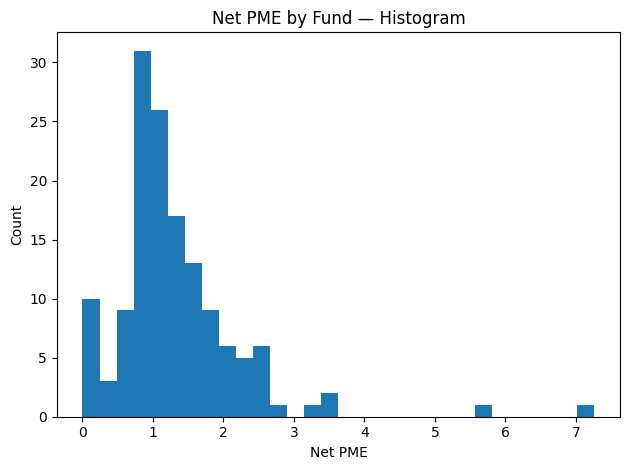

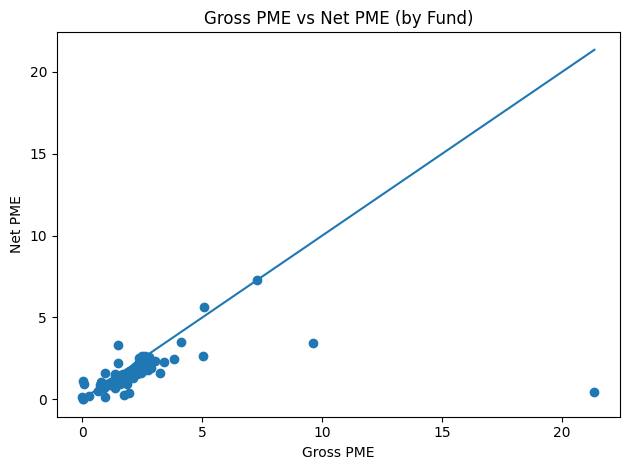

[TABLE] Wrote per-fund GROSS vs NET PME to /Users/michael/Library/Mobile Documents/com~apple~CloudDocs/Studium TUM/Master Management and Technology/06 Master Thesis/00 Thesis/05Code/GrossToNet/Data/per_fund_gross_vs_net_pme.csv


In [138]:
# ---------- 9) Nice outputs (consistent pooled + per-fund; optional NAV-as-residual) ---------- #
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INCLUDE_NAV_AS_RESIDUAL = True  # <- toggle this ON to include latest NAV as terminal distribution

def _amt_col(df):
    return "amount_usd" if "amount_usd" in df.columns else "amount"

# Load composite
comp = load_composite_usd_series()

# Standardize fund types
tcol = "type_std" if "type_std" in funds.columns else "cash_flow_type"
acol = _amt_col(funds)

funds_std = funds.copy()
funds_std[tcol] = funds_std[tcol].astype(str).str.strip().str.lower()

# Optionally add latest NAV per fund as a synthetic positive distribution at its date
if INCLUDE_NAV_AS_RESIDUAL:
    nav_last = (funds_std[funds_std[tcol].eq("nav")]
                .sort_values("date")
                .groupby("fund_id", as_index=False)
                .tail(1)[["fund_id","date",acol]])
    if not nav_last.empty:
        nav_last = nav_last.assign(**{tcol: "distribution", acol: nav_last[acol].clip(lower=0)})
        funds_for_net = pd.concat([funds_std, nav_last], ignore_index=True)
    else:
        funds_for_net = funds_std
else:
    funds_for_net = funds_std

# ---------------- POOLED PME ---------------- #
# Gross (deals): investments <0, proceeds/fair_value >0
deals_cf = deals[["date", _amt_col(deals)]].dropna()
gross_pme = ks_pme_ratio(deals_cf, comp)

# Net (funds): contributions/distributions only; include NAV if toggled (already injected)
funds_cf = funds_for_net.loc[
    funds_for_net[tcol].isin(["contribution","distribution"]),
    ["date", acol]
].dropna()
net_pme = ks_pme_ratio(funds_cf, comp)

fee_drag = gross_pme - net_pme

print(f"POOLED GROSS PME : {gross_pme:0.3f}")
print(f"POOLED NET   PME : {net_pme:0.3f}")
print(f"FEE DRAG (ΔPME) : {fee_drag:0.3f}")

# ---------------- PER-FUND NET PME ---------------- #
# Option 2 (exclude funds with no distributions) when NAV not included,
# otherwise compute PME for everyone (many will now have a terminal dist).
if INCLUDE_NAV_AS_RESIDUAL:
    net_by_fund = ks_pme_all_funds(funds_for_net, index_series=comp).rename("net_pme")
else:
    # exclude funds with no distributions to avoid misleading zeros
    def _net_pme_excl_no_dists(g: pd.DataFrame) -> float:
        g = g[g[tcol].isin(["contribution","distribution"])]
        if not (g[tcol].eq("distribution") & (g[acol] > 0)).any():
            return np.nan
        return ks_pme_ratio(g.rename(columns={acol: "amount"})[["date","amount"]], comp, amount_col="amount")
    net_by_fund = (funds_for_net.groupby("fund_id", dropna=False, group_keys=False)
                              .apply(_net_pme_excl_no_dists)
                              .rename("net_pme"))

# Quartiles and table
valid = net_by_fund.dropna()
if len(valid) >= 4:
    ranks = valid.rank(method="first")
    q = pd.qcut(ranks, q=4, labels=["Q1 (low)","Q2","Q3","Q4 (high)"])
    perf = (net_by_fund.to_frame().join(q.rename("quartile"))).sort_values("net_pme", ascending=False)
else:
    perf = net_by_fund.to_frame().assign(quartile=pd.Series(index=net_by_fund.index, dtype="object")) \
                                 .sort_values("net_pme", ascending=False)

DATA_DIR = find_upwards(Path("GrossToNet/Data"))
OUT_TAB  = DATA_DIR / "per_fund_net_pme.csv"
perf.reset_index(names="fund_id").to_csv(OUT_TAB, index=False)
print(f"[TABLE] Wrote per-fund NET PME table to {OUT_TAB}")

# Top/bottom preview
k = min(10, len(perf))
if k > 0:
    print("\nTop funds (NET PME):")
    print(perf.head(k).round(3).to_string())
    print("\nBottom funds (NET PME):")
    print(perf.tail(k).round(3).to_string())

# ---------------- Histogram ---------------- #
vals = valid.values
if len(vals) >= 1:
    plt.figure()
    plt.hist(vals, bins=30)
    plt.title("Net PME by Fund — Histogram")
    plt.xlabel("Net PME")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# ---------------- Scatter: Gross vs Net PME (by fund) ---------------- #
# Requires a deal→fund map to compute gross PME per fund.
MAP_CSV = DATA_DIR / "deal_to_fund.csv"
if MAP_CSV.exists():
    map_df = pd.read_csv(MAP_CSV, dtype={"deal_id": str, "fund_id": str})
    deals_mapped = deals.merge(map_df, on="deal_id", how="inner")

    gross_by_fund = {}
    for fid, g in deals_mapped.groupby("fund_id"):
        g_cf = g[["date", _amt_col(g)]].dropna()
        if not g_cf.empty:
            gross_by_fund[fid] = ks_pme_ratio(g_cf, comp)
    gross_by_fund = pd.Series(gross_by_fund, name="gross_pme")

    comp_df = pd.concat([gross_by_fund, net_by_fund], axis=1).dropna().sort_index()
    if not comp_df.empty:
        plt.figure()
        plt.scatter(comp_df["gross_pme"], comp_df["net_pme"])
        lo = float(np.nanmin([comp_df["gross_pme"].min(), comp_df["net_pme"].min()]))
        hi = float(np.nanmax([comp_df["gross_pme"].max(), comp_df["net_pme"].max()]))
        plt.plot([lo, hi], [lo, hi])  # 45° line
        plt.title("Gross PME vs Net PME (by Fund)")
        plt.xlabel("Gross PME")
        plt.ylabel("Net PME")
        plt.tight_layout()
        plt.show()

        OUT_PAIR = DATA_DIR / "per_fund_gross_vs_net_pme.csv"
        comp_df.reset_index(names="fund_id").to_csv(OUT_PAIR, index=False)
        print(f"[TABLE] Wrote per-fund GROSS vs NET PME to {OUT_PAIR}")
    else:
        print("[SCATTER] No overlapping funds with both gross and net PME; scatter skipped.")
else:
    print("[SCATTER] deal_to_fund.csv not found; per-fund gross PME unavailable, scatter skipped.")


In [139]:
# classify flows
type_col = "type_std" if "type_std" in funds.columns else "cash_flow_type"
f = funds.copy()
f[type_col] = f[type_col].astype(str).str.strip().str.lower()
f = f[f[type_col].isin(["contribution","distribution","nav"])]

amt_col = "amount_usd" if "amount_usd" in f.columns else "amount"

diag = (f
    .assign(is_contrib=lambda d: d[type_col].eq("contribution") & (d[amt_col] < 0),
            is_dist   =lambda d: d[type_col].eq("distribution") & (d[amt_col] > 0))
    .groupby("fund_id")
    .agg(
        n_contribs=("is_contrib","sum"),
        n_dists   =("is_dist","sum"),
        contrib_usd=("amount_usd" if "amount_usd" in f.columns else "amount",
                     lambda s: float((-s[f.loc[s.index, type_col].eq("contribution")]).clip(lower=0).sum())),
        dist_usd   =("amount_usd" if "amount_usd" in f.columns else "amount",
                     lambda s: float(( s[f.loc[s.index, type_col].eq("distribution")]).clip(lower=0).sum())),
        first_cf   =("date","min"),
        last_cf    =("date","max"),
    )
    .sort_values(["n_dists","n_contribs","last_cf"], ascending=[True,False,True])
)
print(diag.head(20))
print("Funds with 0 distributions:", int((diag["n_dists"]==0).sum()))


                                      n_contribs  n_dists   contrib_usd  \
fund_id                                                                   
fa0efd76-2038-4d6a-9320-96161947d4c1          24        0  4.619000e+07   
67887aca-0647-4bf9-ae52-92fe6f605112          24        0  1.868021e+08   
3fe1201f-9b36-4dbd-b357-734d278b3aaf          23        0  2.770015e+09   
d08d2ffd-97c7-468a-8b66-ae2a29d98386          23        0  2.770015e+09   
11819587-075c-4dd0-b2e6-bd8ce107928e          15        0  7.895977e+08   
aeecf9d6-f152-4616-9cd0-a869909f9108          15        0  3.895466e+07   
75bd0419-879d-4eb9-84f8-0a046f199e6c          14        0  7.883867e+08   
5b8b991b-36eb-458c-8bc6-c5e8df179e0e          12        0  6.382126e+08   
5d681926-2666-40b3-b674-7eefff3db378          12        0  3.480102e+07   
a42295c6-3d00-4ce1-9bca-65e593184378          11        0  1.632092e+09   
0c8625df-adfb-466a-9457-4ff30606c2c8          10        0  5.380685e+09   
5f0f2fb9-43a1-4e82-9de2-8

In [140]:
# ========= Normal Block ==============
net_by_fund = ks_pme_all_funds(funds, index_series=comp).rename("net_pme")
perf = (
    net_by_fund.to_frame()
    .assign(
        quartile=lambda d: pd.qcut(d["net_pme"].rank(method="first"), q=4, labels=["Q1 (low)","Q2","Q3","Q4 (high)"])
                           if d["net_pme"].notna().sum() >= 4 else pd.Series(index=d.index, dtype="object")
    )
    .sort_values("net_pme", ascending=False)
)


# ========= Option 2 — exclude funds with no distributions
# --- replace your current per-fund PME line with this block ---
comp = load_composite_usd_series()
tcol = "type_std" if "type_std" in funds.columns else "cash_flow_type"
acol = "amount_usd" if "amount_usd" in funds.columns else "amount"

funds_std = funds.copy()
funds_std[tcol] = funds_std[tcol].astype(str).str.strip().str.lower()

def _net_pme_excl_no_dists(g: pd.DataFrame) -> float:
    g2 = g[g[tcol].isin(["contribution","distribution"])].copy()
    has_dist = (g2[tcol].eq("distribution") & (g2[acol] > 0)).any()
    if not has_dist:
        return np.nan
    df = g2.rename(columns={acol: "amount"})
    return ks_pme_ratio(df[["date","amount"]], comp, amount_col="amount")

net_by_fund = (
    funds_std.groupby("fund_id", dropna=False, group_keys=False)
             .apply(_net_pme_excl_no_dists)
             .rename("net_pme")
)


# ========== Option 3 — include latest NAV as a terminal “distribution”
# --- replace your current per-fund PME line with this block ---
comp = load_composite_usd_series()
tcol = "type_std" if "type_std" in funds.columns else "cash_flow_type"
acol = "amount_usd" if "amount_usd" in funds.columns else "amount"

funds_std = funds.copy()
funds_std[tcol] = funds_std[tcol].astype(str).str.strip().str.lower()

# add latest NAV per fund as a synthetic positive distribution
nav_last = (funds_std[funds_std[tcol].eq("nav")]
            .sort_values("date")
            .groupby("fund_id", as_index=False)
            .tail(1)[["fund_id","date",acol]])
if not nav_last.empty:
    nav_last = nav_last.assign(**{tcol: "distribution", acol: nav_last[acol].clip(lower=0)})
    funds_with_nav = pd.concat([funds_std, nav_last], ignore_index=True)
else:
    funds_with_nav = funds_std

# now compute net PME per fund (all have a terminal dist if NAV existed)
net_by_fund = ks_pme_all_funds(funds_with_nav, index_series=comp).rename("net_pme")


/var/folders/qd/xj9tr7rx0hg2pt0j07wqkvcc0000gn/T/ipykernel_3252/3379539135.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_net_pme_excl_no_dists)
